In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tvb.simulator.lab import *
import types

In [17]:


connectivities = np.stack([
    np.array([[1.0, 0.2],
              [0.2, 1.0]]),
    np.array([[2.0, 0.4],
              [0.4, 2.0]]),
    np.array([[3.0, 0.8],
              [0.8, 3.0]])
], axis=2)  # shape (2, 2, 3)

# 2) Build one Connectivity object (we’ll swap its weights in place)
conn = connectivity.Connectivity(
    weights       = connectivities[...,0],
    tract_lengths = np.ones((2,2)),
    region_labels = np.array(["R1","R2"], dtype="<U128"),
    centres       = np.array([[0,0,0],[1,0,0]])
)

# 3) Instantiate the low-level Simulator once and configure it
sim = simulator.Simulator(
    model= models.Generic2dOscillator(),
    connectivity= conn,
    coupling    = coupling.Linear(a=np.array([0.0126])),
    integrator  = integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(nsig=np.array([0.001]))),
    monitors    = (monitors.TemporalAverage(period=1.0),
                   monitors.Bold(period=1000.0)),
)
sim.configure()   # ← sets up both the ODE integrator and the Balloon model


# 1) initialize a place to store the last‐seen weights
sim._last_weights = None

# 2) save the original method
original_compute = sim._loop_compute_node_coupling

# 3) define a wrapper that only prints when weights differ
def logged_compute(self, step):
    current = self.connectivity.weights
    # compare to last; note exact equality since we’re using simple floats
    if self._last_weights is None or not np.array_equal(current, self._last_weights):
        print(f"[Step {step}] connectivity.weights changed to:\n{current}\n")
        # store a copy for next comparison
        self._last_weights = current.copy()
    return original_compute(step)

# 4) bind it onto our sim instance
sim._loop_compute_node_coupling = types.MethodType(logged_compute, sim)

all_times = []
all_bold  = []
all_tavg_times = []
all_tavg_data  = []
slice_dur = 20_000.0

for k in range(3):
    # swap in the next connectivity slice
    sim.connectivity.weights = connectivities[..., k]
    # run the next 20 s of simulation—state is preserved
    print(f"Running slice {k+1} with connectivity weights:\n{sim.connectivity.weights}")
    sim.simulation_length = slice_dur  # Set simulation length for this run
    out = sim.run()
    (t_tavg, d_tavg), (t_b, d_b) = out
    all_times.append(t_b)
    all_bold.append(d_b)
    all_tavg_times.append(t_tavg)
    all_tavg_data.append(d_tavg)

full_time = np.concatenate(all_times)
print(full_time)
full_bold = np.concatenate(all_bold, axis=0)

full_tavg_time = np.concatenate(all_tavg_times)
full_tavg_data = np.concatenate(all_tavg_data, axis=0)



Running slice 1 with connectivity weights:
[[1.  0.2]
 [0.2 1. ]]
[Step 1] connectivity.weights changed to:
[[1.  0.2]
 [0.2 1. ]]

Running slice 2 with connectivity weights:
[[2.  0.4]
 [0.4 2. ]]
[Step 20001] connectivity.weights changed to:
[[2.  0.4]
 [0.4 2. ]]

Running slice 3 with connectivity weights:
[[3.  0.8]
 [0.8 3. ]]
[Step 40001] connectivity.weights changed to:
[[3.  0.8]
 [0.8 3. ]]

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.
 31000. 32000. 33000. 34000. 35000. 36000. 37000. 38000. 39000. 40000.
 41000. 42000. 43000. 44000. 45000. 46000. 47000. 48000. 49000. 50000.
 51000. 52000. 53000. 54000. 55000. 56000. 57000. 58000. 59000. 60000.]


In [18]:
# Check if the time axis is continuous

dts = np.diff(full_time)
if np.all(dts == 1000.0):
    print("✅ Time axis is continuous: all Δt = 1000 ms")
else:
    bad = np.where(dts != 1000.0)[0]
    for idx in bad:
        print(f"⚠️  Gap or overlap at index {idx}: "
              f"{full_time[idx]} → {full_time[idx+1]} = {dts[idx]} ms")

✅ Time axis is continuous: all Δt = 1000 ms


Text(0.5, 0, 'Time (ms)')

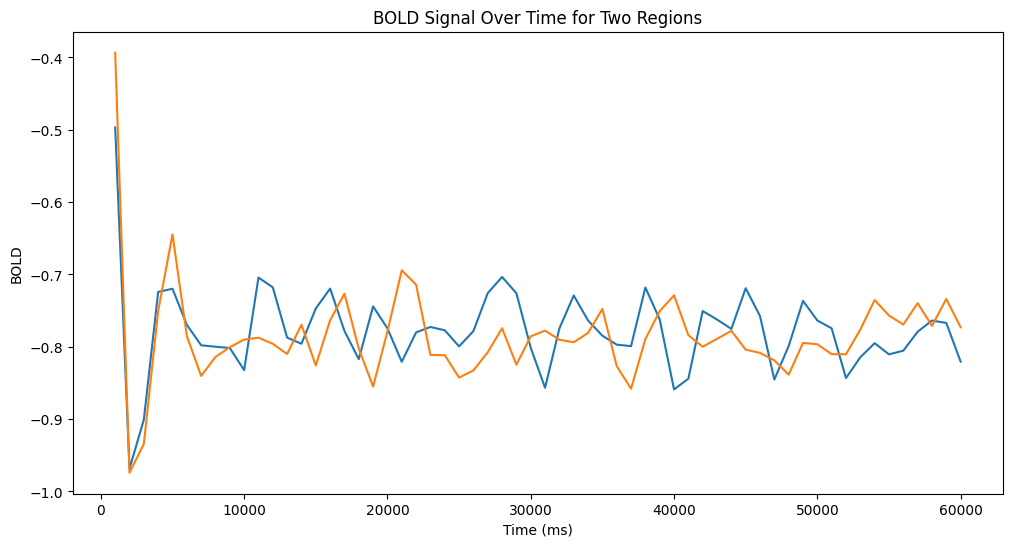

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(full_time, full_bold[:, 0, :, 0])
plt.ylabel("BOLD")
plt.title("BOLD Signal Over Time for Two Regions")
plt.xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

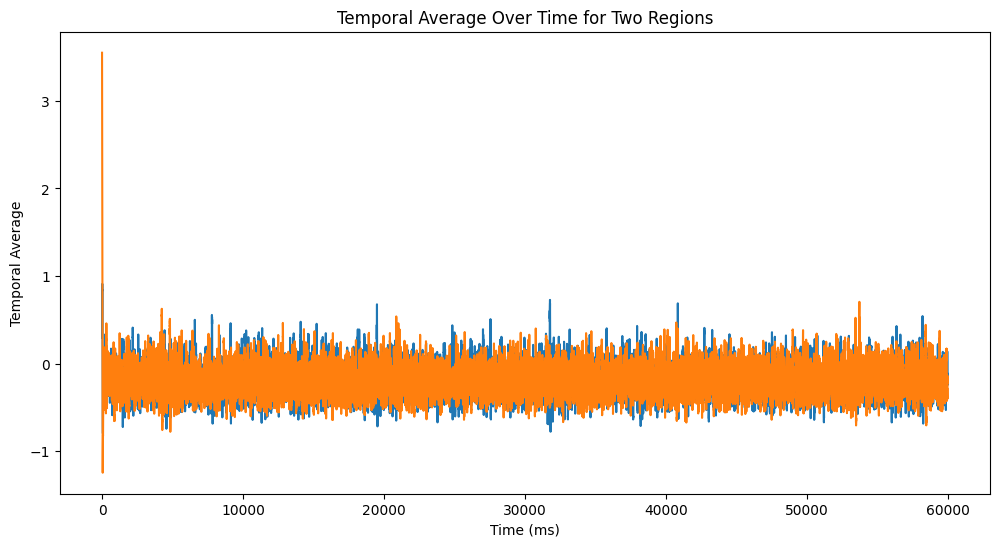

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(full_tavg_time, full_tavg_data[:, 0, :, 0])
plt.ylabel("Temporal Average")
plt.title("Temporal Average Over Time for Two Regions")
plt.xlabel('Time (ms)')